In [1]:
import json
import os
from PIL import Image, ImageDraw

# Load the JSON file
with open('dataset_all\dataset\labels_facade_dataset_2024-06-09-08-43-50.json', 'r') as f:
    data = json.load(f)

# Create the masks directory if it doesn't exist
os.makedirs('masks', exist_ok=True)

# Iterate through each image in the JSON data
for image_details in data['images']:
    image_path = f"dataset_all\dataset/{image_details['file_name']}"

    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Image {image_path} does not exist.")
        continue

    # Get the annotations for the current image
    annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_details['id']]

    # Load the image to get its dimensions
    image = Image.open(image_path)
    width, height = image.size

    # Create a blank mask
    mask = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask)
    '''
    # Draw the polygons on the mask for walls
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_id'] == 2:
            polygon = [(x, y) for x, y in zip(ann['segmentation'][0][::2], ann['segmentation'][0][1::2])]
            draw.polygon(polygon, outline=50, fill=100)
    '''
    # Draw the polygons on the mask for windows
    for ann in annotations:
        if ann['category_id'] == 1: 
            polygon = [(x, y) for x, y in zip(ann['segmentation'][0][::2], ann['segmentation'][0][1::2])]
            draw.polygon(polygon, outline=50, fill=255)

    # Save the mask
    mask_filename = f"masks/mask_{image_details['file_name'].replace('.jpg', '.png')}"
    mask.save(mask_filename)
    print(f"Saved mask for {image_details['file_name']} to {mask_filename}")


Saved mask for rectified_facade_DENW11AL0000CnBT.jpg to masks/mask_rectified_facade_DENW11AL0000CnBT.png
Saved mask for rectified_facade_DENW11AL0000FnLF.jpg to masks/mask_rectified_facade_DENW11AL0000FnLF.png
Saved mask for rectified_facade_DENW11AL0000FnLG.jpg to masks/mask_rectified_facade_DENW11AL0000FnLG.png
Saved mask for rectified_facade_DENW11AL0000h2yB.jpg to masks/mask_rectified_facade_DENW11AL0000h2yB.png
Saved mask for rectified_facade_DENW11AL0000h3GA.jpg to masks/mask_rectified_facade_DENW11AL0000h3GA.png
Saved mask for rectified_facade_DENW11AL0000h3GC.jpg to masks/mask_rectified_facade_DENW11AL0000h3GC.png
Saved mask for rectified_facade_DENW11AL0000h3GE.jpg to masks/mask_rectified_facade_DENW11AL0000h3GE.png
Saved mask for rectified_facade_DENW11AL0000h3GF.jpg to masks/mask_rectified_facade_DENW11AL0000h3GF.png
Saved mask for rectified_facade_DENW11AL0000h3GH.jpg to masks/mask_rectified_facade_DENW11AL0000h3GH.png
Saved mask for rectified_facade_DENW11AL0000h3GI.jpg to

shuffle

In [2]:
import os
import shutil
import random
from glob import glob

# Set seed for reproducibility
random.seed(42)

# Define paths
dataset_path = 'dataset_all\dataset'
masks_path = 'dataset_all\masks'
output_path = 'data_2'

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Create directories
for split in ['train', 'val', 'test']:
    for subfolder in ['images', 'masks']:
        os.makedirs(os.path.join(output_path, split, subfolder), exist_ok=True)

# Get list of images and masks
images = glob(os.path.join(dataset_path, '*.jpg'))
masks = glob(os.path.join(masks_path, 'mask_*.png'))

# Ensure corresponding masks are available
image_names = [os.path.basename(image) for image in images]
mask_names = ['mask_' + os.path.splitext(name)[0] + '.png' for name in image_names]

# Pair images with their masks
data_pairs = [(img, os.path.join(masks_path, mask)) for img, mask in zip(images, mask_names) if os.path.exists(os.path.join(masks_path, mask))]

# Shuffle the data
random.shuffle(data_pairs)

# Split the data
total_count = len(data_pairs)
train_count = int(total_count * train_ratio)
val_count = int(total_count * val_ratio)

train_pairs = data_pairs[:train_count]
val_pairs = data_pairs[train_count:train_count + val_count]
test_pairs = data_pairs[train_count + val_count:]

# Function to copy files to designated folders
def copy_files(pairs, split):
    for img, mask in pairs:
        shutil.copy(img, os.path.join(output_path, split, 'images', os.path.basename(img)))
        shutil.copy(mask, os.path.join(output_path, split, 'masks', os.path.basename(mask)))

# Copy files to train, val, and test folders
copy_files(train_pairs, 'train')
copy_files(val_pairs, 'val')
copy_files(test_pairs, 'test')

print(f"Total images: {total_count}")
print(f"Training images: {len(train_pairs)}")
print(f"Validation images: {len(val_pairs)}")
print(f"Test images: {len(test_pairs)}")


Total images: 49
Training images: 34
Validation images: 9
Test images: 6


Transform to tensor

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class FacadeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [file for file in os.listdir(image_dir) if file.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = f"mask_{os.path.splitext(img_name)[0]}.png"
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Directories for training, validation, and testing
train_image_dir = os.path.join("data_2", "train", "images")
train_mask_dir = os.path.join("data_2", "train", "masks")

val_image_dir = os.path.join("data_2", "val", "images")
val_mask_dir = os.path.join("data_2", "val", "masks")

test_image_dir = os.path.join("data_2", "test", "images")
test_mask_dir = os.path.join("data_2", "test", "masks")

# Create datasets
train_dataset = FacadeDataset(train_image_dir, train_mask_dir, transform=transform)
val_dataset = FacadeDataset(val_image_dir, val_mask_dir, transform=transform)
test_dataset = FacadeDataset(test_image_dir, test_mask_dir, transform=transform)

print("train dataset", train_dataset)
print("validation dataset", val_dataset)
print("test dataset", test_dataset)


train dataset 34
validation dataset <__main__.FacadeDataset object at 0x0000017406C3E230>
test dataset <__main__.FacadeDataset object at 0x0000017406C3E3E0>


Prepare Data Loaders

In [2]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train dataset:", len(train_dataset))
print("Validation dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

Train dataset: 34
Validation dataset: 9
Test dataset: 6


Checking the input data

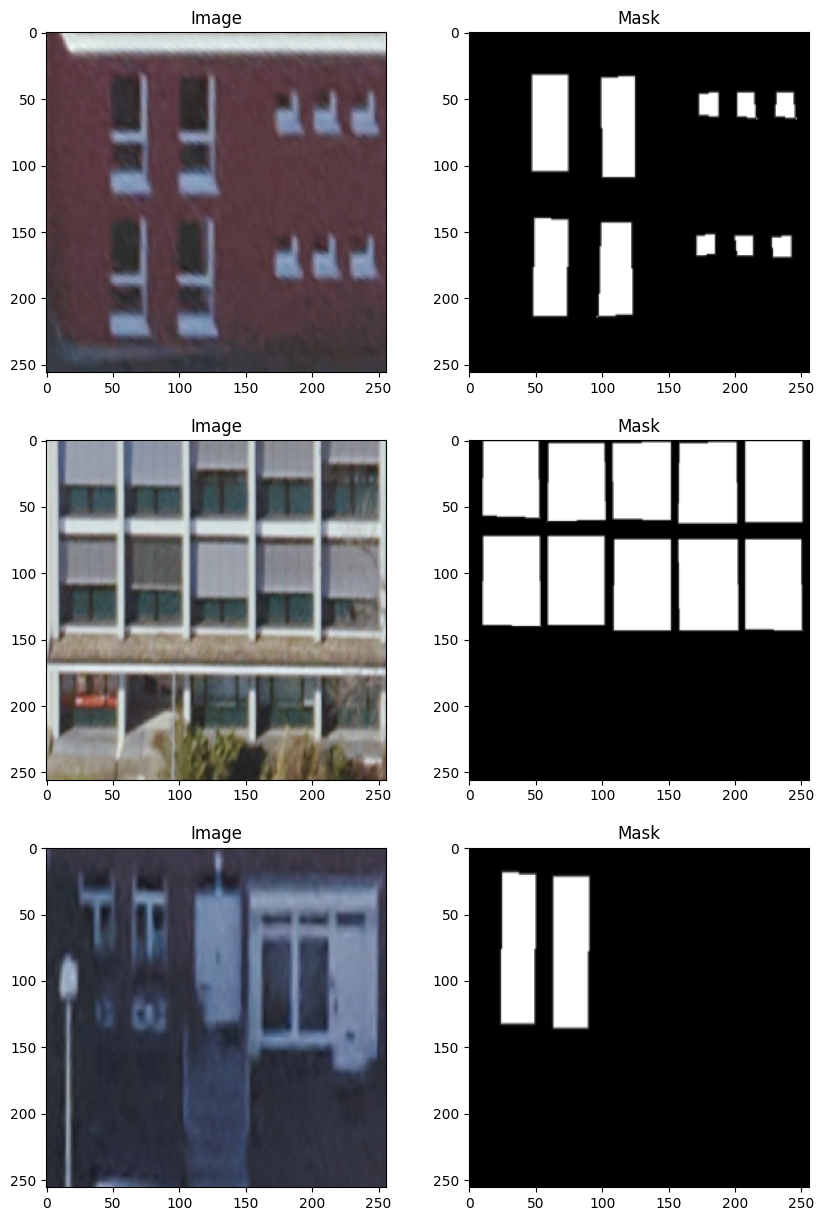

In [3]:
import matplotlib.pyplot as plt

# Visualize some samples
def visualize_samples(dataset, num_samples=3):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.permute(1, 2, 0))  # assuming image is in (C, H, W) format and needs permute to (H, W, C)
        axs[i, 0].set_title('Image')
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')  # squeeze to remove single channel dimension
        axs[i, 1].set_title('Mask')
    plt.show()

visualize_samples(train_dataset)

Define The Model

In [4]:
import torchvision.models as models

# Load a pre-trained FCN model
model = models.segmentation.fcn_resnet50(pretrained=True)

# Modify the classifier for 1 class (window vs. facade)
model.classifier[4] = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))

c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train The Model

In [5]:
import torch.optim as optim
import torch.nn as nn

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Ensure data is on the same device as model
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/50, Loss: 0.6754641056060791
Epoch 2/50, Loss: 0.5149288058280945
Epoch 3/50, Loss: 0.414770770072937
Epoch 4/50, Loss: 0.35889814496040345
Epoch 5/50, Loss: 0.32331374287605286
Epoch 6/50, Loss: 0.2922554314136505
Epoch 7/50, Loss: 0.2523979604244232
Epoch 8/50, Loss: 0.2325653612613678
Epoch 9/50, Loss: 0.21799488365650177
Epoch 10/50, Loss: 0.2057792514562607
Epoch 11/50, Loss: 0.20999161303043365
Epoch 12/50, Loss: 0.1959739327430725
Epoch 13/50, Loss: 0.18614383041858673
Epoch 14/50, Loss: 0.17679888904094695
Epoch 15/50, Loss: 0.17719217538833618
Epoch 16/50, Loss: 0.17264712154865264
Epoch 17/50, Loss: 0.1779083400964737
Epoch 18/50, Loss: 0.1605856090784073
Epoch 19/50, Loss: 0.1623103529214859
Epoch 20/50, Loss: 0.15504914224147798
Epoch 21/50, Loss: 0.1529501348733902
Epoch 22/50, Loss: 0.1420487105846405
Epoch 23/50, Loss: 0.13652569949626922
Epoch 24/50, Loss: 0.13451496958732606
Epoch 25/50, Loss: 0.13856301754713057
Epoch 26/50, Loss: 0.12755291163921356
Epoch 27/

Checking the Predicitons

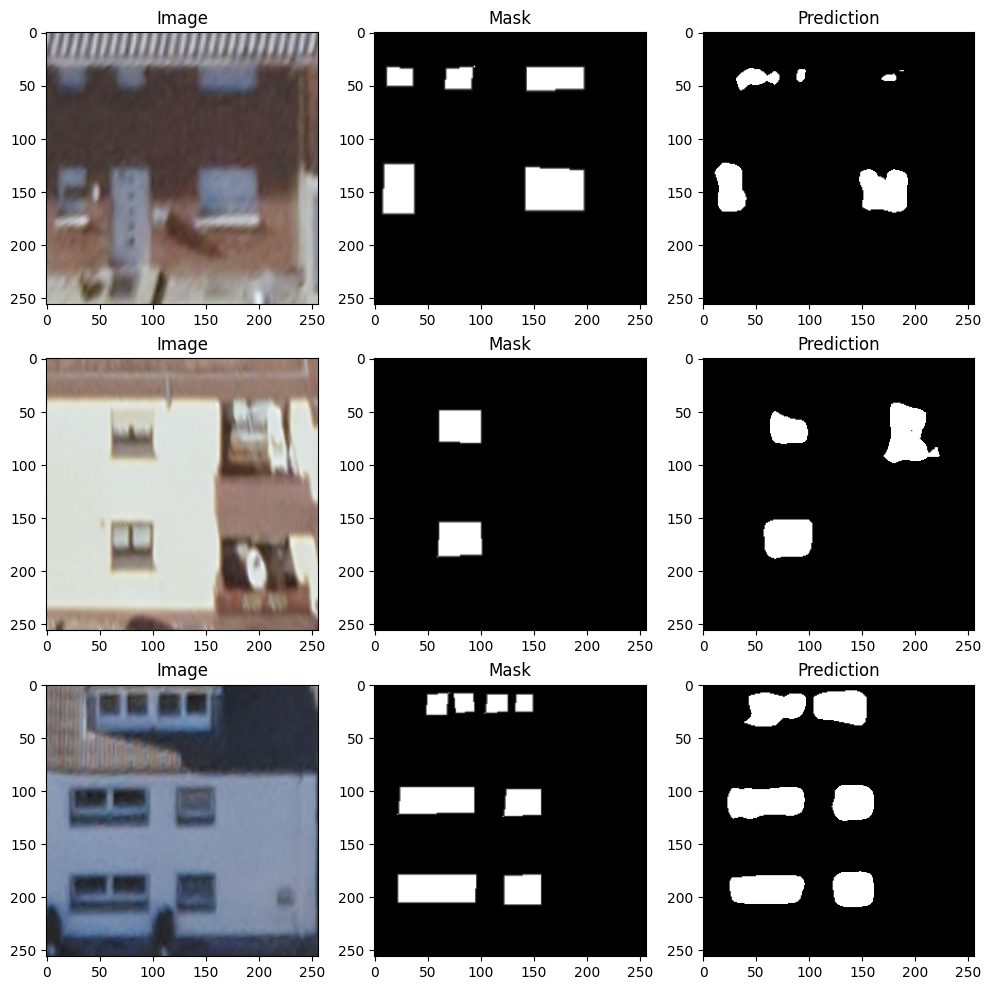

In [6]:
import matplotlib.pyplot as plt
import torch

# Get a batch of validation data
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)['out']
    outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = outputs > 0.5  # Threshold to get binary predictions

# Plot some sample images and their predictions
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    axs[i, 0].imshow(images[i].cpu().permute(1, 2, 0))  # Assuming image is in (C, H, W) format
    axs[i, 0].set_title('Image')
    axs[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
    axs[i, 1].set_title('Mask')
    axs[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
    axs[i, 2].set_title('Prediction')

plt.show()


In [ ]:
# not sure about it yet

import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

# Define the image path
image_path = "cmp_b0001.jpg"

# Load the image and preprocess it
image = Image.open(image_path).convert("RGB")
transform = T.Compose([
    T.Resize((256, 256)),  # Resize to match model input size
    T.ToTensor()           # Convert to tensor
])
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Set the model to evaluation mode and get prediction
model.eval()
with torch.no_grad():
    output = model(image_tensor)['out']
    output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
    pred = output > 0.5  # Threshold to get binary predictions

# Visualize the original image, ground truth mask (if available), and prediction
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(masks[0].cpu().squeeze(), cmap='gray')  # Assuming you have a corresponding mask
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred[0].cpu().squeeze(), cmap='gray')
axs[2].set_title('Model Prediction')

plt.show()


NameError: name 'device' is not defined